# Sensitivity Analysis for RL Control Policies

### Phase 1 - Train

- train policy in simulation

### Phase 2 - Analysis

given min/max bounds for inputs and outputs from training, 

In [1]:
# imports
import os
import torch

# local imports
from utils import (
    rollout2trajectory,
    compute_jacobian,
    compute_sensitivity,
    compute_batch_multistep_sensitivity,
    compute_perturbation_error,
    compute_batch_perturbation_error,
    plot_matrix,
    plot_1d,
    plot_semilogy,
    plot_multistep_sensitivity,
    plot_perturbation_error,
)

In [2]:
# load policy
export_dir = "../logs/point_mass/2025-11-27_12-15-37/exported"
policy_path = os.path.join(export_dir, "policy_jit.pt")
rollout_path = os.path.join(export_dir, "rollout.pt")
io_path = os.path.join(export_dir, "policy_io.txt")
policy = torch.jit.load(policy_path).eval()
rollout = torch.load(rollout_path)
with open(io_path, "r") as f:
    print(f.read())
rollout_obs, rollout_actions, rollout_dones = rollout2trajectory(rollout)
print(f"Rollout Data: {rollout_obs.numpy().shape}")

<ActionManager> contains 1 active terms.
+----------------------------------+
|  Active Action Terms (shape: 2)  |
+-------+--------------+-----------+
| Index | Name         | Dimension |
+-------+--------------+-----------+
|   0   | joint_effort |         2 |
+-------+--------------+-----------+

<ObservationManager> contains 1 groups.
+---------------------------------------------------+
| Active Observation Terms in Group: 'policy' (shape: (4,)) |
+--------------+---------------------+--------------+
|    Index     | Name                |    Shape     |
+--------------+---------------------+--------------+
|      0       | pose                |     (2,)     |
|      1       | velocity            |     (2,)     |
+--------------+---------------------+--------------+

Rollout Data: (100, 8192, 4)


### Sensitivity Matrix

#### Global (Uniform Prior vs. Policy Rollout)
$$C_\rho = \mathbb{E}_{x\sim \rho(x_0)}\left [ J(x)^T J(x) \right ]$$
$$C_\pi = \mathbb{E}_{x\sim\mathcal{X}_\text{rollout}}\left [ J(x)^T J(x) \right ]$$

#### Local
$$C(x) = J(x)^T J(x)$$

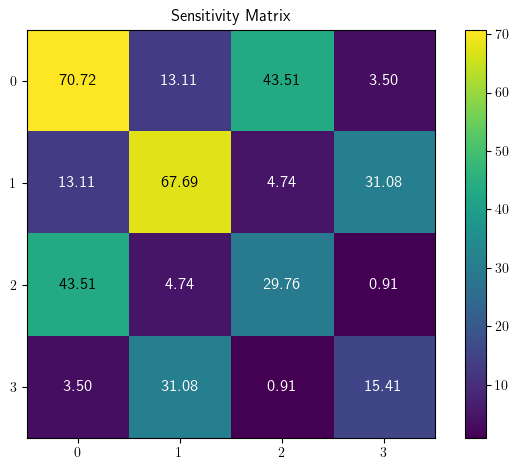

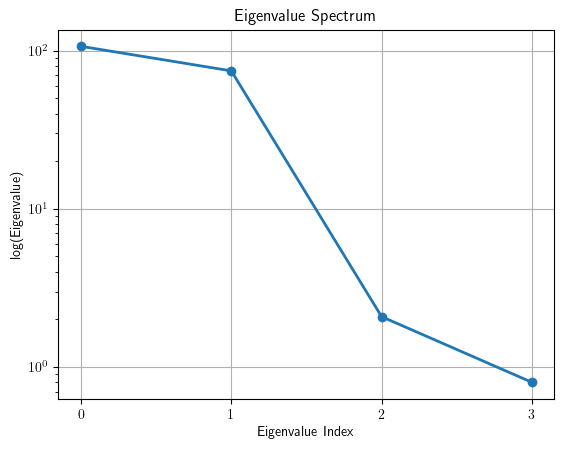

In [3]:
r = torch.empty(1_000, 4, dtype=torch.float32)
states = r.uniform_(-1.0, 1.0)
# states[:, 0:2] = 0.001
# states[:, 2:4] = 0.0
C, eigvals, eigvecs, explained_energy, input_activity = compute_sensitivity(policy, states)
plot_matrix(C, "Sensitivity Matrix")
plot_semilogy(eigvals, "Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)")

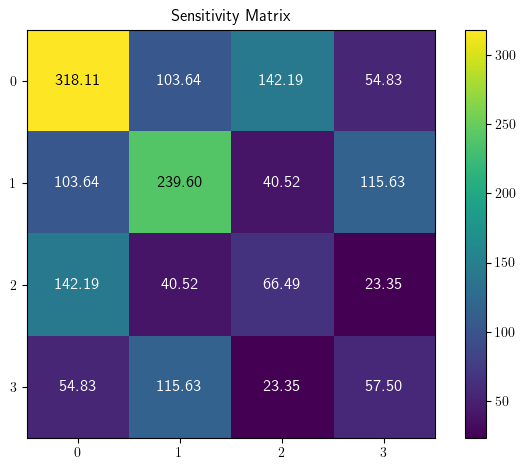

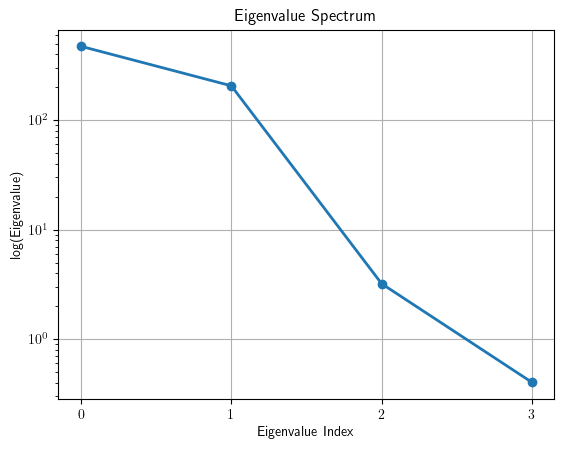

In [4]:
# sensitivity matrix
states = rollout_obs.reshape(-1, 4)
C, eigvals, eigvecs, explained_energy, input_activity = compute_sensitivity(policy, states)
plot_matrix(C, "Sensitivity Matrix")
plot_semilogy(eigvals, "Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)")

### Spectral Analysis
$$Cv=\lambda v$$

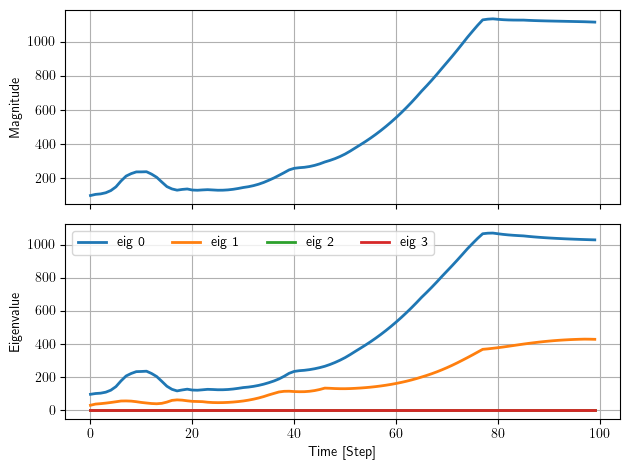

In [5]:
C_traj, eig_traj = compute_batch_multistep_sensitivity(policy, rollout_obs)
plot_multistep_sensitivity(C_traj, eig_traj, log=False)

### Explained Energy
$$E_i=\frac{\sum_j^i\lambda_j}{\sum\lambda}$$

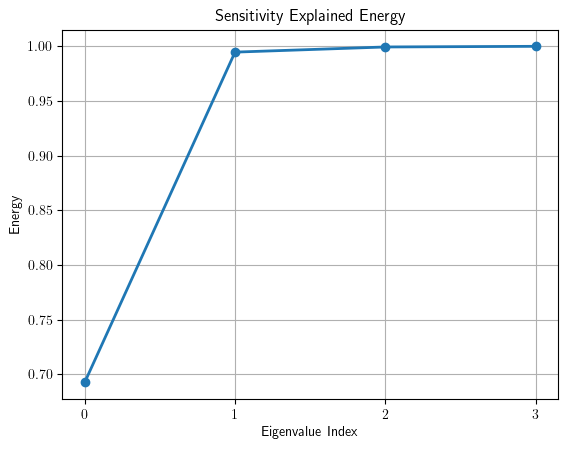

In [6]:
plot_1d(explained_energy, "Sensitivity Explained Energy", "Eigenvalue Index", "Energy")

### Active Subspace
$$\alpha_i=\sum_j\lambda_jv_{ji}^2$$

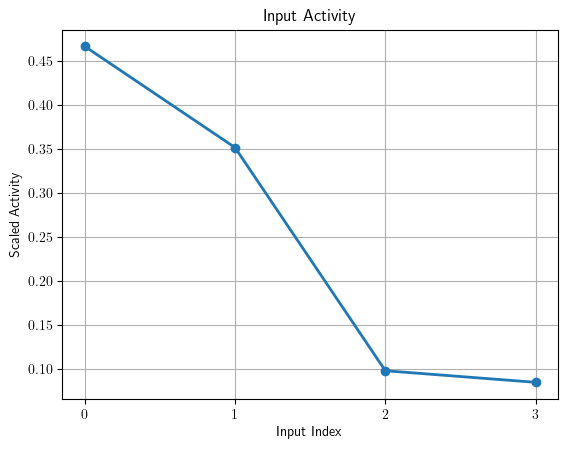

In [7]:
plot_1d(input_activity, "Input Activity", "Input Index", "Scaled Activity")

### Sensitivity to Perturbation
$$\max_{v}||\pi(x+\alpha v) - \pi(x)|| \approx \alpha||J(x) v||$$

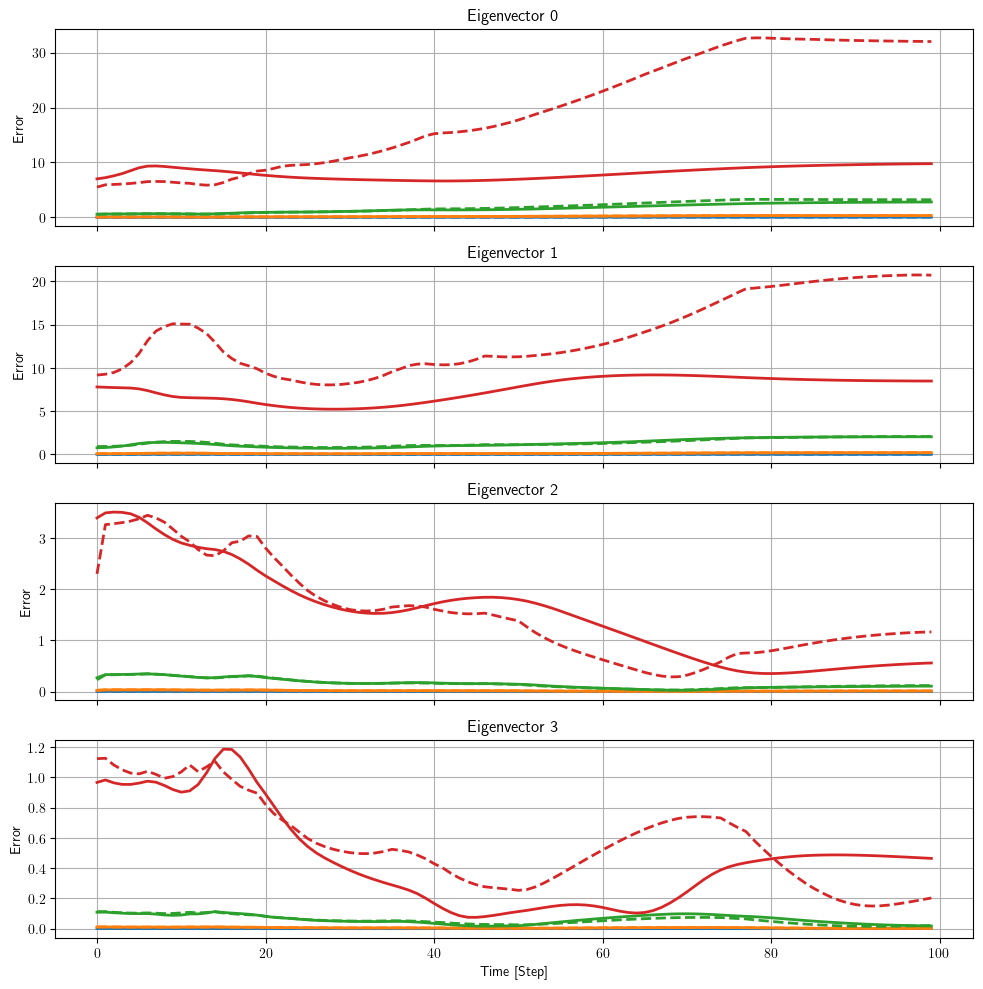

In [8]:
radii = [0.001, 0.01, 0.1, 1.0]
errors, errors_linear = compute_perturbation_error(policy, rollout_obs, eigvecs, radii, env_idx=0)
plot_perturbation_error(errors, errors_linear, eigvecs, radii, log=False)

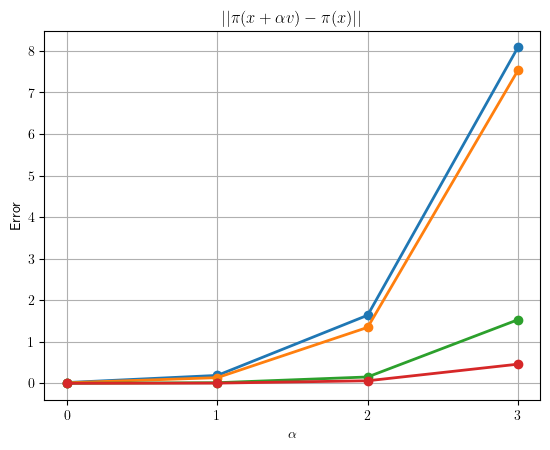

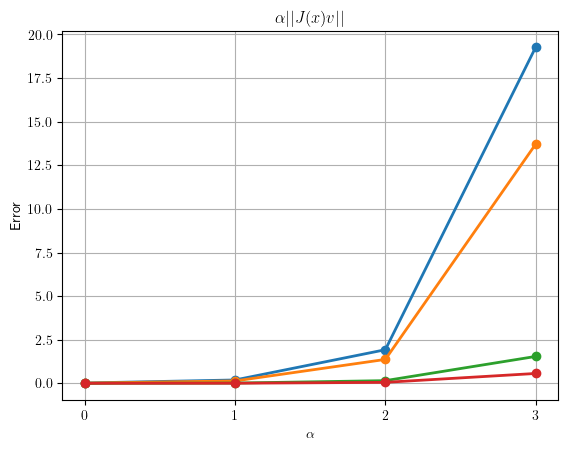

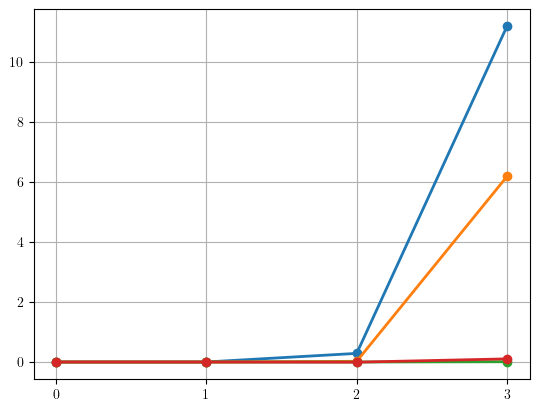

In [9]:
errors, errors_linear = compute_batch_perturbation_error(policy, rollout_obs, eigvecs, radii)
plot_1d(errors.T, r"$||\pi(x+\alpha v) - \pi(x)||$", r"$\alpha$", "Error")
plot_1d(errors_linear.T, r"$\alpha||J(x)v||$", r"$\alpha$", "Error")
plot_1d(errors_linear.T - errors.T, "", "", "")